In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings
from scipy import misc

In [13]:
# Display function for CIFAR-10
def display(image):
    plt.imshow(misc.toimage(image.reshape((3, 32, 32)).transpose(1,2,0)), interpolation = 'gaussian')
    plt.show()

In [14]:
data_directory_path = '../Datasets/cifar-10-batches-py'

In [15]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [16]:
def loadBatch(filepath):
    """
    Loads the input data from the CIFAR-10 file given by filepath, encodes
    the labels given by scalars into hot key encoding vectors and returns
    the (X, Y, y) tuple where X is the inputs, Y the hotkey encodings and
    y and scalar labels.
    """
    dataset = unpickle(filepath)
    dataSamples = dataset[b'data'] / 255
    labels = dataset[b'labels']
    label_count = np.max(labels)
    hotKeyEncodings = np.array([[0 if labels[i] != j else 1 for j in range(label_count + 1)] for i in range(len(labels))])
    return dataSamples, hotKeyEncodings, labels

In [17]:
class Params:
    """
    Class containing hyperparameters used for
    gradient descent learning.
    
    Attributes:
        n_batch: Number of samples in each mini-batch.
        eta: Learning rate
        n_epochs: Maximum number of learning epochs.
    """
    def __init__(self, n_batch, eta, n_epochs):
        """ Constructor """
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [35]:
def softmax(s):
    """
    Implementation of the softmax activation function

    Args:
        s: an 1xd vector of a classifier's outputs

    Returns:
        An 1xd vector with the results of softmax given the input
        vector s.
    """
    exponents = np.exp(s - np.max(s, axis = 0)) # Max subtraction for numerical stability
    output_exp_sum = np.sum(exponents, axis = 0)
    p = exponents / output_exp_sum
    return p

In [36]:
def ReLU(s):
    """
    Implementation of the Rectified Linear Units (ReLU) activation function.

    Args:
        s: an 1xd vector of a classifier's outputs

    Returns:
        An 1xd vector with the results of softmax given the input
        vector s.
    """
    s[s < 0.0] = 0.0
    return s

In [44]:
class FeedforwardNet():
    """
    A two layered feedforward network with linear activation
    functions, cross entropy loss and a softmax output layer.

    Attributes:
        K: list with number of nodes of each layer
        d: dimensions of input in the first layer
        W: A list with the weight matrices of each layer.
        b: A list with the bias vectors of each layer.
        layers: number of layers for the network.
        activationFunc: A list of the activation functions being used at each layer
    """


    def __init__(self, d, K, mean, s, layers, activationFunc):
        """
        Initializes the Weight matrix and the bias vector
        with a Gaussian distribution.

        Args:
            d: input dimensions
            K: list with number of nodes of each layer
            mean: mean of Gaussian
            s: standard deviation of Gaussian
            layers: number of layers in the network
            activationFunc: A list of the activation functions being used at each layer

        Raises:
            Exception if K does not have exactly one number for each layer for
                its number of neurons.
        Returns:
            A tuple with the weight matrix W and the bias vector b
                in this order.
        """
        self.d = d
        # If K does not have exactly as many elements as the layers
        if(not(isinstance(K, list) and len(K) == layers)):
            raise Exception("K should have exactly one number for each layer for \
                its number of neurons")
            
        if(not(isinstance(activationFunc, list) and len(activationFunc) == layers)):
            raise Exception("activationFunc should be a list with exactly one activation function \
                            for each layer for its number of neurons")
        
        self.activationFunc = activationFunc    
        self.K = K
        self.layers = layers
        tmp = list([d])
        tmp.extend(K) # layers + 1 elements
        self.W = [np.random.normal(mean, s, (tmp[i + 1], tmp[i])) for i in range(self.layers)]
        self.b = [np.zeros((tmp[i + 1], 1)) for i in range(self.layers)]

    def evaluateClassifier(self, X):
        """
        Evaluates the output of the classifier given the weights,
        the bias and the inputs.

        Args:
            X: An Nxd matrix with the N d-dimensional input samples.

        Returns:
            A tuple with the  Kx1 output vector of the neural network passed through
            the softmax activation function, the unactivated outputs in each layer 
            as well as the inputs of each layer.
        """
        layer_inputs = [X.T]
        output = np.dot(self.W[0], X.T) + self.b[0]
        unactivated_outputs = [output]
        output = self.activationFunc[0](output)
        # Compute output for each layer
        for i in range(1,layers):
            layer_inputs.append(output)
            output = np.dot(self.W[i], output) + self.b[i]
            unactivated_outputs.append(output)
            output = self.activationFunc[i](output)
        return (output, unactivated_outputs, layer_inputs)

    def computeCost(self, X, Y, lamda, scale_const = 1e+6):
        """
        Evaluates the loss function of the network.

        Args:
            X: Input matrix
            Y: Output matrix
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
            scale_const: constant used to temporarily scale up possibly
                small floating point numbers to avoid precision errors caused
                by summing a lot of small numbers.
        Returns:
            A scalar corresponding to the loss.
        """
        return np.mean(scale_const * self.cross_entropy_loss(X, Y)) / scale_const \
                + lamda * sum([np.sum(scale_const * np.power(self.W[i], 2))] for i\
                              in range(self.layers))/ scale_consts

    def cross_entropy_loss(self, X, Y):
        """
        Calculates the cross entropy loss
        """
        log_X = np.multiply(Y.T , self.evaluateClassifier(X)[0]).sum(axis=0)
        log_X[log_X == 0] = np.finfo(float).eps
        return -np.log(log_X)


    def computeAccuracy(self, X, y):
        """
        Computes the accuracy of the network.

        Args:
            X: Input matrix
            y: Output labels

        Returns:
            The accuracy of the network (i.e. the percentage of
            correctly classified inputs in X).

        """
        softmax_outputs = self.evaluateClassifier(X)[0] # Get probability distribution of outputs
        # Reduce to a vector of the labels with the highest probability
        predictions = np.argmax(softmax_outputs, axis = 0)
        accuracy = (predictions == y).mean()
        return accuracy

    def computeGradients(self, X, Y, lamda, method = "analytical"):
        """
        Computes the gradient of the error with the regularization
        term with respect to the weights and the bias. Currently works
        only for one ReLU layer followed by a softmax layer and cross
        entropy loss.

         Args:
            X: Input matrix
            Y: Desired output matrix
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
            method: Type of method to be used to evaluate the gradients.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """

        if method == "analytical":
            # Analytical computation of the gradient
            return self.computeAnalyticalGradients(X, Y, lamda)
        elif method == "fast_numerical":
            # Faster but less accurate calculation of the gradients
            return self.computeGradsNum(X, Y, lamda)
        elif method == "accurate_numerical":
            # More exact calculation of the gradients but slower
            return self.computeGradsNumSlow(X, Y, lamda)


    def computeGradsNum(self, X, Y, lamda, h = 1e-8):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the finite difference method.

         Args:
            X: Input matrix
            Y: Desired output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """
        P = self.evaluateClassifier(X)[0]
        N = X.shape[0]
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)

        c = self.computeCost(X, Y, lamda);

        for i in range(self.b.shape[0]):
            self.b[i] += h;
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h;
            grad_b[i] = (c2-c) / h;

        W_try = np.copy(self.W)
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                self.W[i, j] += h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i, j] -= h
                grad_W[i, j] = (c2-c) / h;

        return (grad_W, grad_b)

    def computeGradsNumSlow(self, X, Y, lamda, h = 1e-8):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the centered difference formula.

         Args:
            X: Input matrix
            Y: Desired output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """
        P = self.evaluateClassifier(X)[0]
        N = X.shape[0]
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)

        for i in range(self.b.shape[0]):
            self.b[i] -= h;
            c1 = self.computeCost(X, Y, lamda);
            self.b[i] += 2 * h
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h
            grad_b[i] = (c2-c1) / (2 * h);

        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                self.W[i,j] -= h
                c1 = self.computeCost(X, Y, lamda);
                self.W[i,j] += 2 * h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i,j] -= h
                grad_W[i,j] = (c2-c1) / (2 * h);

        return (grad_W , grad_b)


    def computeAnalyticalGradients(self, X, Y, P, lamda):
        """
        Computes the gradient of the error function w.r.t the
        weights analytically.

        Args:
            X: Input matrix
            Y: Desired output matrix
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A list of tuples with the gradients w.r.t the weights
            and the bias of each layer.
            That is, [(grad_W0, grad_b0), (grad_W1, grad_b1), ...].
        """
        # Run forward pass
        P, unactivated_outputs, layer_inputs = self.evaluateClassifier(X)
        # Initialize gradient matrices to zeros
        grad_W = [np.zeros(self.W[i].shape) for i in range(self.layers)]
        grad_b = [np.zeros(self.b[i].shape) for i in range(self.layers)]
        N = X.shape[0] # Number of samples in the batch
        
        for i in range(N):
            x = X[i].reshape(1,-1)
            y = Y[i].reshape(-1,1)
            p = P[:,i]
            g = -(y - p)
            grad_b[1] += g
            grad_W[1] += g.dot(layer_inputs[1][i])
            tmp = np.where(unactivated_outputs[1][i] > 0, 1, 0)
            g = g.dot(W[1]).dot(np.diag(tmp))
            grad_b[0] += g
            grad_W[0] += g.dot(layer_inputs[0][i])
        grad_b[1] /= N
        grad_W[1] /= N
        grad_b[0] /= N
        grad_W[0] /= N
        grad_W[0] += 2 * lamda * self.W[0]
        grad_W[1] += 2 * lamda * self.W[1]
        return (grad_W, grad_b)

    def miniBatchGD(self, X, Y, GDparams, lamda, GDmethod = "analytical", verbose = False, X_val = None, Y_val = None):
        """
        Implementation of mini-batch gradient descent.

         Args:
            X: Training input matrix
            Y: Training set desired output matrix
            GDparams: Object of the class Params with the hyperparameters
                used for learning.
            W: Initial weight matrix
            b: Initial bias vector
            lamda: Constant that determines the amount
                of loss induced by the regularization term.
            GDmethod: Method used to approximate gradient descent.
            verbose: Prints info in each iteration about the progress of
                training when equal to True.
            X_val: Validation set input matrix
            Y_val: Validation set desired output matrix

        Returns:
            The following tuple is returned where the validation lists
            are empty if no validation set is given: (training_loss_list,
            validation_loss_list, training_acc_list, validation_acc_list).
        """
        results = ([],[],[],[])
        mini_batch_count = X.shape[0] // GDparams.n_batch
        y = np.argmax(Y.T, axis = 0)
        if(X_val is not None and Y_val is not None):
            y_val = np.argmax(Y_val.T, axis = 0)

        results[0].append(self.computeCost(X, Y, lamda))
        results[2].append(network_model.computeAccuracy(X, y))
        if(X_val is not None and Y_val is not None):
            results[1].append(self.computeCost(X_val, Y_val, lamda))
            results[3].append(network_model.computeAccuracy(X_val, y_val))
        if(verbose):
                print("Starting state ")
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))

        for i in range(GDparams.n_epochs):
            for j in range(mini_batch_count):
                if(j < mini_batch_count - 1):
                    start = j * GDparams.n_batch
                    end = start + GDparams.n_batch
                    mini_batch_input = X[start:end]
                    mini_batch_output = Y[start:end]
                else:
                    # Take the remaining samples in the last mini batch
                    mini_batch_input = X[j * GDparams.n_batch:]
                    mini_batch_output = Y[j * GDparams.n_batch:]
                grad_W, grad_b = self.computeGradients(mini_batch_input, mini_batch_output,
                                                    lamda, method = GDmethod)
                self.W -= GDparams.eta * grad_W
                self.b -= GDparams.eta * grad_b

            results[0].append(self.computeCost(X, Y, lamda))
            results[2].append(network_model.computeAccuracy(X, y))
            if(X_val is not None and Y_val is not None):
                results[1].append(self.computeCost(X_val, Y_val, lamda))
                results[3].append(network_model.computeAccuracy(X_val, y_val))
            if(verbose):
                print("Iteration " + str(i))
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))

        return results

In [19]:
def normalizeInputs(X):
    """
    Normalizes inputs so that they have zero mean

    Attributes:
        X: The matrix to be normalized with each row representing a different
            input.
    Returns:
        A tuple with first the matrix with the same dimensionality as X but
        normalized and second a vector with the mean vector used for normalization.
    """
    means = np.mean(X, axis = 0)
    return (X - means, means)

In [20]:
def makePlots(tr_losses, val_losses, tr_accuracies, val_accuracies):
    plt.subplot(1,2,1)
    plt.plot(tr_losses, 'r-', label='Train')
    plt.plot(val_losses, 'b-', label='Validation')
    plt.title('Cost function')
    plt.xlabel('Epoch')
    plt.ylabel('Cost value')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(tr_accuracies, 'r-', label='Training data')
    plt.plot(val_accuracies, 'b-', label='Validation data')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [21]:
def visualizeWeights(network):
    # Visualize learned weights as pictures
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(network_model.W)):
        plt.subplot(2, 5, i+1)
        plt.axis("off")
        plt.imshow(misc.toimage(network.W[i].reshape((3, 32, 32)).transpose(1,2,0)), interpolation = 'gaussian')
    plt.show()

In [22]:
def getRelativeErrors(grad1, grad2):
    """
    Computes the relative errors of grad_1 and grad_2 gradients
    """
    abs_diff = np.absolute(grad1 - grad2) 
    abs_sum = np.absolute(grad1) + np.absolute(grad2)
    max_elems = np.where(abs_sum > np.finfo(float).eps, abs_sum, np.finfo(float).eps)
    relativeErrors = abs_diff / max_elems
    return relativeErrors

In [23]:
BatchList = []
for i in range(1,6):
    Xnew, Ynew, ynew = loadBatch(data_directory_path + '/data_batch_' + str(i))
    BatchList.append((Xnew, Ynew, ynew))

In [24]:
# Holdout data from training data for the validation set
X_tr, Y_tr, y_tr  = BatchList[0]
X_val, Y_val, y_val = BatchList[1]

In [25]:
# Load test data
X_tst, Y_tst, y_tst = loadBatch(data_directory_path + '/test_batch')

In [26]:
# Normalize all data
X_tr, norm_means = normalizeInputs(X_tr)
X_val -= norm_means # Normalize validation set
X_tst -= norm_means # Normalize test set

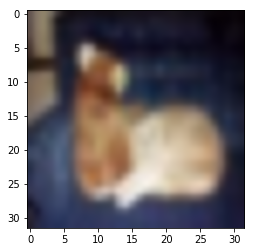

In [27]:
# Visualize an image for debugging reasons

image_index = 17
display(X_tr[image_index])

### Running the network's functions without training

In [48]:
N = X_tr.shape[0] # Number of samples
d = X_tr.shape[1] # Input dimensionality
K = [50, Y_tr.shape[1]] # Output dimensionality
layers = 2
mean = 0.0
standard_deviation = 0.001
network_model = FeedforwardNet(d, K, mean, standard_deviation, layers = 2, activationFunc = [ReLU, softmax])
# Checking that the function works on a subset of inputs
P = network_model.evaluateClassifier(X_tr[:100])[0]
sums = np.sum(P, axis = 0)
print("SUMS OF PROBABILITIES IN THE OUTPUTS: " + str(sums)) # Check if the sums for each sample sum up to 1
#cost = network_model.computeCost(X_tr, Y_tr, lamda = 0)
#print("LOSS FUNCTION VALUE: " + str(cost))
#acc = network_model.computeAccuracy(X_tr, y_tr)
#print("ACCURACY: " + str(acc))

SUMS OF PROBABILITIES IN THE OUTPUTS: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


### Debugging gradients